In [56]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [57]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, text
from pathlib import Path
from datetime import datetime, timedelta

In [59]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [60]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine) #CHATGPT HELP


In [61]:
# View all of the classes that automap found
print("Available classes:", Base.classes.keys())

Available classes: ['station', 'measurement']


In [62]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [63]:
# reflect the station table
print("Columns in station table:", station.__table__.columns.keys())


Columns in station table: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [64]:
# reflect the measurement table
print("Columns in measurement table:", measurement.__table__.columns.keys())


Columns in measurement table: ['id', 'station', 'date', 'prcp', 'tobs']


In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [66]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

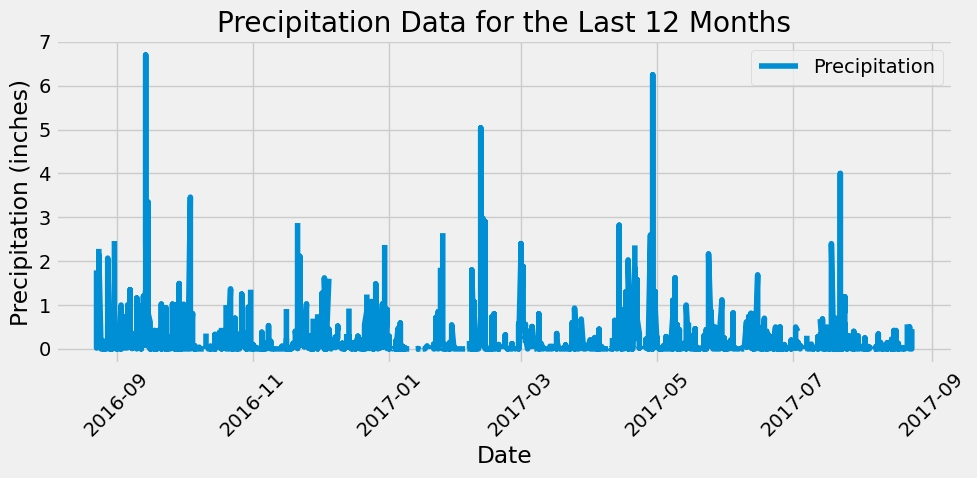

In [67]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# USED CHATGPT FOR HELP ON THIS CELL
# Starting from the most recent data point in the database. 
recent_date_time = datetime.strptime(recent_date, "%Y-%m-%d") #covert recent date string to datetime object
                                     
# Calculate the date one year from the last date in data set.
one_year_ago = recent_date_time - timedelta(days=365)  # Subtract 365 days

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago.strftime("%Y-%m-%d")).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['prcp'], label='Precipitation')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [68]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(df['prcp'].describe())

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [69]:
# Design a query to calculate the total number of stations in the dataset
unq_stations = session.query(station.station).distinct().count()
unq_stations

9

In [70]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
unq_stations_count = session.query(measurement.station, func.count(measurement.station))\
                        .group_by(measurement.station)\
                        .order_by(func.count(measurement.station).desc()).all()

unq_stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
act_unq_station = unq_stations_count[0][0] 

# Query to calculate the lowest, highest, and average temperature for the most active station
temp_stat = session.query(
    func.min(measurement.tobs),  # Minimum temperature
    func.max(measurement.tobs),  # Maximum temperature
    func.avg(measurement.tobs)   # Average temperature
).filter(measurement.station == act_unq_station).all()

# Print the results
temp_stat

[(54.0, 85.0, 71.66378066378067)]

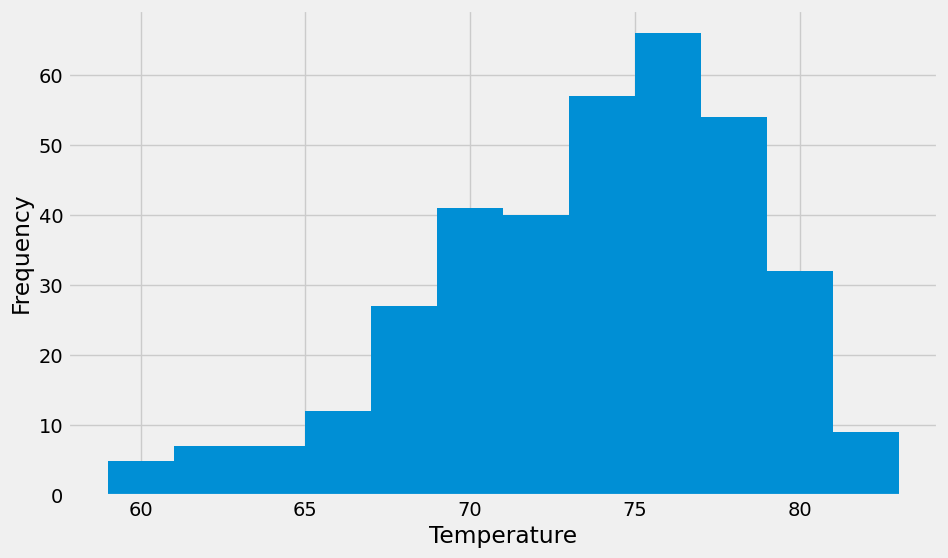

In [72]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find the most recent date in the data set for the most active station
rec_date_stat = session.query(func.max(measurement.date)).filter(measurement.station == act_unq_station).scalar()
rec_date_time_stat = datetime.strptime(rec_date_stat, "%Y-%m-%d")

# Calculate the date one year ago from the most recent date
one_year_ago = rec_date_time_stat - timedelta(days=365)

# Step 3: Query the last 12 months of temperature data for the most active station
temp_data = session.query(measurement.tobs)\
                          .filter(measurement.station == act_unq_station)\
                          .filter(measurement.date >= one_year_ago.strftime("%Y-%m-%d"))\
                          .all()


# Convert the result into a list of temperatures
temp_values = [temp[0] for temp in temp_data]

# Step 4: Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_values, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [73]:
# Close Session
session.close()
